In [1]:
import json
import os
from pathlib import Path

import cv2
import matplotlib
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO

from utils.preprocess import get_labels_by_image, get_image_by_labels
from utils.preprocess import xyxy_reformat, rect_include_another

matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline

load_dotenv()


/opt/miniconda3/envs/pt113/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


True

In [7]:
yolo_model_dir = Path(os.getenv('YOLO_MODEL_DIR'))
yolo_dir = yolo_model_dir / '..'
model = YOLO(yolo_model_dir / 'enumerate.pt')
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'


In [3]:
target_labels = ['caries', 'filling', 'endo', 'post', 'crown', 'R.R']
# df = pd.read_csv('label_TF.csv', index_col='filename')
image_labels_df = get_image_by_labels()
# image_labels_df = df[target_labels]
# image_labels_df = get_image_by_labels(target_labels)[target_labels]

image_labels_df['crown'].sum()


635

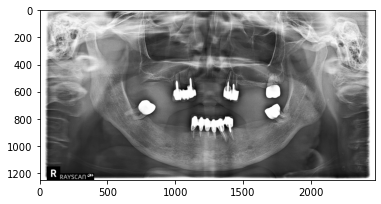

In [82]:
# filename = image_labels_df.index[1]
filename = '202011280911378711866_0560927A'
filepath_image = data_dir / f'{filename}.jpg'
filepath_json = data_dir / f'{filename}.json'

im = cv2.imread(filepath_image)
plt.imshow(im)
plt.show()



image 1/1 /Users/lucyxu/PycharmProjects/datasets/phase-2/202011280911378711866_0560927A.jpg: 352x640 1 27, 1 31, 1 32, 1 33, 1 41, 2 42s, 1 43, 81.3ms
Speed: 5.3ms preprocess, 81.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


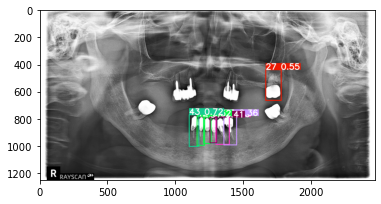

In [85]:
# Image
# Inference
results = model(filepath_image, boxes=False)

res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()


# One file check

In [22]:
names = np.array(list(model.names.values()))
labels = get_labels_by_image(filepath_json, target_labels)
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs

    image_labels = {}
    for i, label in enumerate(labels):
        xyxy = np.hstack(label['points'])  # [x, y, x, y]
        xyxy = xyxy_reformat(np.array([xyxy]))[0]

        for box in boxes:
            # print(box.xyxy)
            tooth_number = names[box.cls.int()]
            tooth_xyxy = box.xyxy
            tooth_xyxy = np.array([np.hstack(tooth_xyxy)]).astype(int)
            tooth_xyxy = xyxy_reformat(tooth_xyxy)[0]

            iou = rect_include_another(tooth_xyxy, xyxy)
            if iou > 0.5:
                # key = f'{filename}-{tooth_number}'
                key = f'{tooth_number}/{filename}'
                if not key in image_labels.keys():
                    image_labels[key] = {}
                image_labels[key][i] = iou

    df = {}
    for k, v in image_labels.items():
        df[k] = [v[i].numpy() if i in v.keys() else np.array(0) for i in range(len(labels))]

    df = pd.DataFrame(df)

    image_labels_after = {}
    max_idxes = df.values.argmax(axis=1)

    for i, max_idx in enumerate(max_idxes):
        tooth_key = df.columns[max_idx]
        if not tooth_key in image_labels_after.keys():
            image_labels_after[tooth_key] = {}

        image_labels_after[tooth_key][i] = labels[i]['label']

    for k, v in image_labels_after.items():
        image_labels_after[k] = set(v.values())

    print(image_labels_after)


{'13/202011280311178751869_0460103A': {'post', 'crown', 'endo'}, '12/202011280311178751869_0460103A': {'crown', 'endo'}, '11/202011280311178751869_0460103A': {'crown', 'endo'}, '21/202011280311178751869_0460103A': {'crown', 'endo'}, '22/202011280311178751869_0460103A': {'crown', 'endo'}, '23/202011280311178751869_0460103A': {'crown', 'endo'}, '24/202011280311178751869_0460103A': {'crown', 'endo'}, '25/202011280311178751869_0460103A': {'endo'}, '26/202011280311178751869_0460103A': {'crown'}, '44/202011280311178751869_0460103A': {'crown', 'endo'}, '43/202011280311178751869_0460103A': {'crown', 'endo'}, '32/202011280311178751869_0460103A': {'crown', 'endo'}, '33/202011280311178751869_0460103A': {'endo'}, '35/202011280311178751869_0460103A': {'post', 'crown', 'endo'}, '42/202011280311178751869_0460103A': {'crown'}, '34/202011280311178751869_0460103A': {'crown'}}


In [122]:
results = model(data_dir, save_crop=True)

results



image 1/600 /Users/lucyxu/PycharmProjects/datasets/phase-2/00006145.jpg: 320x640 1 11, 1 12, 2 13s, 2 14s, 2 15s, 2 16s, 1 17, 1 21, 1 22, 1 23, 1 26, 1 28, 1 31, 1 32, 1 33, 1 34, 1 35, 1 37, 1 41, 1 42, 1 43, 2 44s, 2 45s, 1 47, 2 48s, 138.6ms
image 2/600 /Users/lucyxu/PycharmProjects/datasets/phase-2/00008026.jpg: 320x640 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 18, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 49.4ms
image 3/600 /Users/lucyxu/PycharmProjects/datasets/phase-2/00008075.jpg: 320x640 1 11, 1 12, 1 13, 1 14, 2 15s, 1 16, 1 17, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 2 47s, 47.2ms
image 4/600 /Users/lucyxu/PycharmProjects/datasets/phase-2/00008113.jpg: 320x640 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 22, 2 23s, 1 24, 1 25, 1 26, 1 27, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 41, 1

[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: '11', 1: '12', 2: '13', 3: '14', 4: '15', 5: '16', 6: '17', 7: '18', 8: '21', 9: '22', 10: '23', 11: '24', 12: '25', 13: '26', 14: '27', 15: '28', 16: '31', 17: '32', 18: '33', 19: '34', 20: '35', 21: '36', 22: '37', 23: '38', 24: '41', 25: '42', 26: '43', 27: '44', 28: '45', 29: '46', 30: '47', 31: '48'}
 orig_img: array([[[182, 182, 182],
         [188, 188, 188],
         [189, 189, 189],
         ...,
         [158, 158, 158],
         [154, 154, 154],
         [161, 161, 161]],
 
        [[193, 193, 193],
         [200, 200, 200],
         [220, 220, 220],
         ...,
         [136, 136, 136],
         [159, 159, 159],
         [164, 164, 164]],
 
        [[205, 205, 205],
         [189, 189, 189],
         [218, 218, 218],
         ...,
         [145, 145, 145],
         [157, 157, 157],
         [157,

In [40]:
results[0].path


'/Users/lucyxu/PycharmProjects/datasets/phase-2/00006145.jpg'

In [75]:
import warnings

warnings.filterwarnings("ignore")

c = 0
image_labels_all = {}
names = np.array(list(model.names.values()))
for result in tqdm(results):
    filepath_image = Path(result.path)
    filepath_json = filepath_image.with_suffix('.json')

    labels = get_labels_by_image(filepath_json, target_labels)
    boxes = result.boxes  # Boxes object for bbox outputs

    image_labels = {}
    for i, label in enumerate(labels):
        xyxy = np.hstack(label['points'])  # [x, y, x, y]
        xyxy = xyxy_reformat(np.array([xyxy]))[0]

        for box in boxes:
            # print(box.xyxy)
            tooth_number = names[box.cls.int()]
            tooth_xyxy = box.xyxy
            tooth_xyxy = np.array([np.hstack(tooth_xyxy)]).astype(int)
            tooth_xyxy = xyxy_reformat(tooth_xyxy)[0]

            iou = rect_include_another(tooth_xyxy, xyxy)
            if iou > 0.5:
                # key = f'{filename}-{tooth_number}'
                key = f'{tooth_number}/{filepath_image.stem}'
                if not key in image_labels.keys():
                    image_labels[key] = {}
                image_labels[key][i] = iou

    df = {}
    for k, v in image_labels.items():
        df[k] = [v[i].numpy() if i in v.keys() else np.array(0) for i in range(len(labels))]

    df = pd.DataFrame(df)

    image_labels_after = {}
    if df.empty:
        max_idxes = []
    else:
        max_idxes = df.values.argmax(axis=1)

    for i, max_idx in enumerate(max_idxes):
        tooth_key = df.columns[max_idx]
        if not tooth_key in image_labels_after.keys():
            image_labels_after[tooth_key] = {}

        image_labels_after[tooth_key][i] = labels[i]['label']

    for k, v in image_labels_after.items():
        image_labels_after[k] = list(set(v.values()))

    # print(df)
    image_labels_all.update(image_labels_after)


100%|██████████| 600/600 [00:08<00:00, 67.67it/s]


In [76]:
image_labels_all


{'14/00006145': ['filling'],
 '15/00006145': ['caries'],
 '26/00008026': ['crown'],
 '36/00008026': ['post', 'crown', 'endo'],
 '11/00008026': ['post', 'crown', 'endo'],
 '21/00008026': ['post', 'crown', 'endo'],
 '46/00008026': ['caries'],
 '12/00008026': ['crown'],
 '22/00008026': ['crown'],
 '18/00008026': ['filling'],
 '32/00008026': ['crown'],
 '36/00008075': ['filling'],
 '46/00008075': ['filling'],
 '47/00008113': ['filling'],
 '46/00008113': ['filling'],
 '24/00008113': ['filling'],
 '23/00008113': ['filling'],
 '25/00008113': ['filling'],
 '26/00008113': ['filling'],
 '27/00008113': ['filling'],
 '38/00008113': ['filling'],
 '14/00008113': ['filling'],
 '16/00008113': ['filling'],
 '17/00008113': ['filling'],
 '37/00008113': ['filling'],
 '36/00008113': ['post', 'crown', 'endo'],
 '11/00008113': ['caries'],
 '12/00008113': ['caries'],
 '41/00008113': ['caries'],
 '35/00008113': ['caries'],
 '15/00008113': ['filling'],
 '16/00008117': ['caries'],
 '23/00008117': ['caries'],
 '2

In [77]:
# for tooth_number, r in region.items():
#     print(r)
# target_roi
# label
# !jupyter nbconvert --to script prepare_classify_format.ipynb

j = json.dumps(image_labels_all)

with open('image_labels_for_classify.json', 'w') as f:
    f.write(j)


## Check crop and origin image annotation count.

In [121]:
crop_annotation_number = {}
for k, v in image_labels_all.items():
    tooth_number, filename = k.split('/')

    if filename not in crop_annotation_number.keys():
        crop_annotation_number[filename] = {i: 0 for i in target_labels}

    for i in v:
        crop_annotation_number[filename][i] += 1

counter_diff = {}
for filename, counter in crop_annotation_number.items():
    counter_diff[filename] = {}

    org_number_row = image_labels_df.loc[filename]
    for k in target_labels:
        counter_diff[filename][k] = org_number_row.loc[k] - counter[k]

counter_diff_df = pd.DataFrame.from_dict(counter_diff, orient='index')
counter_diff_df = counter_diff_df.loc[(counter_diff_df > 2).any(axis=1)]

idxes = np.argsort(counter_diff_df.sum(axis=1))
idxes = idxes[::-1]
counter_diff_df.iloc[idxes]


,caries,filling,endo,post,crown,R.R
202011280911378711866_0560927A,0,0,7,5,3,0
00008527,0,0,2,2,1,6
00008377,0,0,4,1,5,0
202011161011067701636_0330301A,0,0,5,2,1,0
201809280909389265470_000924,0,0,3,1,3,0
202011301111438901895_0771116A,0,4,3,0,0,0
00008488,0,0,5,1,1,0
00008526,0,0,3,0,4,0
00008154,0,0,3,0,3,0
202011170911357821651_0251109A,0,0,3,0,3,0
